# Think Bayes: Chapter 9

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot

## Improving Reading Ability

From DASL(http://lib.stat.cmu.edu/DASL/Stories/ImprovingReadingAbility.html)

> An educator conducted an experiment to test whether new directed reading activities in the classroom will help elementary school pupils improve some aspects of their reading ability. She arranged for a third grade class of 21 students to follow these activities for an 8-week period. A control classroom of 23 third graders followed the same curriculum without the activities. At the end of the 8 weeks, all students took a Degree of Reading Power (DRP) test, which measures the aspects of reading ability that the treatment is designed to improve.

> Summary statistics on the two groups of children show that the average score of the treatment class was almost ten points higher than the average of the control class. A two-sample t-test is appropriate for testing whether this difference is statistically significant. The t-statistic is 2.31, which is significant at the .05 level.



I'll use Pandas to load the data into a DataFrame.

In [2]:
import pandas as pd

df = pd.read_csv('drp_scores.csv', skiprows=21, delimiter='\t')
df.head()

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58
3,Treated,71
4,Treated,43


And use `groupby` to compute the means for the two groups.

In [3]:
grouped = df.groupby('Treatment')
for name, group in grouped:
    print(name, group.Response.mean())

Control 41.5217391304
Treated 51.4761904762


The `Normal` class provides a `Likelihood` function that computes the likelihood of a sample from a normal distribution.

In [4]:
from scipy.stats import norm
from thinkbayes2 import EvalNormalPdf

class Normal(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: sequence of test scores
        hypo: mu, sigma
        """
        mu, sigma = hypo
        likes = EvalNormalPdf(data, mu, sigma)
        return np.prod(likes)

The prior distributions for `mu` and `sigma` are uniform.

In [5]:
mus = np.linspace(20, 80, 101)
sigmas = np.linspace(5, 30, 101)

I use `itertools.product` to enumerate all pairs of `mu` and `sigma`.

In [6]:
from itertools import product

control = Normal(product(mus, sigmas))
data = df[df.Treatment=='Control'].Response
control.Update(data)

1.791883192150766e-44

After the update, we can plot the probability of each `mu`-`sigma` pair as a contour plot.

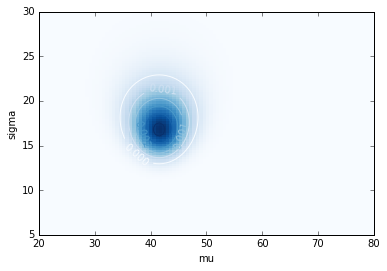

In [7]:
thinkplot.Contour(control, pcolor=True)
thinkplot.Config(xlabel='mu', ylabel='sigma')

And then we can extract the marginal distribution of `mu`

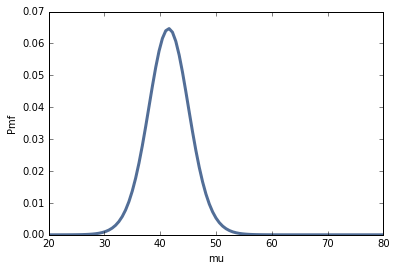

In [8]:
pmf_mu0 = control.Marginal(0)
thinkplot.Pdf(pmf_mu0)
thinkplot.Config(xlabel='mu', ylabel='Pmf')

And the marginal distribution of `sigma`

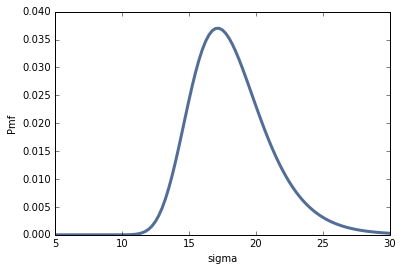

In [9]:
pmf_sigma0 = control.Marginal(1)
thinkplot.Pdf(pmf_sigma0)
thinkplot.Config(xlabel='sigma', ylabel='Pmf')

**Exercise:** Run this analysis again for the control group.  What is the distribution of the difference between the groups?  What is the probability that the average "reading power" for the treatment group is higher?  What is the probability that the variance of the treatment group is higher?

In [10]:
# Solution

treated = Normal(product(mus, sigmas))
data = df[df.Treatment=='Treated'].Response
treated.Update(data)

4.5285690956159087e-37

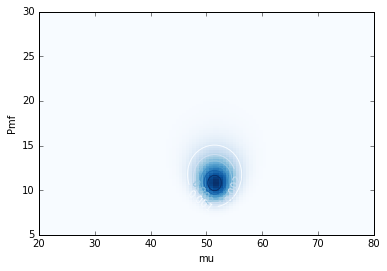

In [11]:
# Solution

# Here's the posterior joint distribution for the treated group

thinkplot.Contour(treated, pcolor=True)
thinkplot.Config(xlabel='mu', ylabel='Pmf')

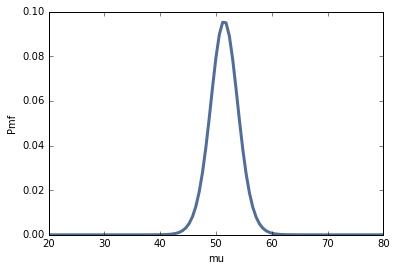

In [12]:
# Solution

# The marginal distribution of mu

pmf_mu1 = treated.Marginal(0)
thinkplot.Pdf(pmf_mu1)
thinkplot.Config(xlabel='mu', ylabel='Pmf')

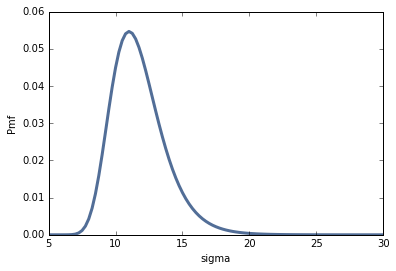

In [13]:
# Solution

# The marginal distribution of sigma

pmf_sigma1 = treated.Marginal(1)
thinkplot.Pdf(pmf_sigma1)
thinkplot.Config(xlabel='sigma', ylabel='Pmf')

In [14]:
# Solution

# Now we can compute the distribution of the difference between groups

pmf_diff = pmf_mu1 - pmf_mu0
pmf_diff.Mean(), pmf_diff.MAP()

(9.9544130889408731, 9.0)

0.019520974812674143

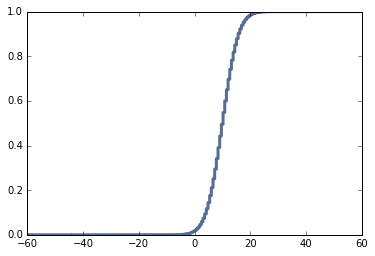

In [15]:
# Solution

# And CDF_diff(0), which is the probability that the difference is <= 0

pmf_diff = pmf_mu1 - pmf_mu0
cdf_diff = pmf_diff.MakeCdf()
thinkplot.Cdf(cdf_diff)
cdf_diff[0]

In [16]:
# Solution

# Or we could directly compute the probability that mu is
# greater than mu2

pmf_mu1.ProbGreater(pmf_mu0)

0.98047902518732777

In [17]:
# Solution

# Finally, here's the probability that the standard deviation
# in the treatment group is higher.

pmf_sigma1.ProbGreater(pmf_sigma0)

0.02688748111057556

In [18]:
# It looks like there is a high probability that the mean of
# the treatment group is higher, and the most likely size of
# the effect is 9-10 points.

# It looks like the variance of the treated group is substantially
# smaller, which suggests that the treatment might be helping
# low scorers more than high scorers.

## Paintball

Suppose you are playing paintball in an indoor arena 30 feet
wide and 50 feet long.  You are standing near one of the 30 foot
walls, and you suspect that one of your opponents has taken cover
nearby.  Along the wall, you see several paint spatters, all the same
color, that you think your opponent fired recently.

The spatters are at 15, 16, 18, and 21 feet, measured from the
lower-left corner of the room.  Based on these data, where do you
think your opponent is hiding?

Here's the Suite that does the update.  It uses `MakeLocationPmf`,
defined below.

In [19]:
class Paintball(Suite, Joint):
    """Represents hypotheses about the location of an opponent."""

    def __init__(self, alphas, betas, locations):
        """Makes a joint suite of parameters alpha and beta.

        Enumerates all pairs of alpha and beta.
        Stores locations for use in Likelihood.

        alphas: possible values for alpha
        betas: possible values for beta
        locations: possible locations along the wall
        """
        self.locations = locations
        pairs = [(alpha, beta) 
                 for alpha in alphas 
                 for beta in betas]
        Suite.__init__(self, pairs)

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: pair of alpha, beta
        data: location of a hit

        Returns: float likelihood
        """
        alpha, beta = hypo
        x = data
        pmf = MakeLocationPmf(alpha, beta, self.locations)
        like = pmf.Prob(x)
        return like

In [20]:
def MakeLocationPmf(alpha, beta, locations):
    """Computes the Pmf of the locations, given alpha and beta. 

    Given that the shooter is at coordinates (alpha, beta),
    the probability of hitting any spot is inversely proportionate
    to the strafe speed.

    alpha: x position
    beta: y position
    locations: x locations where the pmf is evaluated

    Returns: Pmf object
    """
    pmf = Pmf()
    for x in locations:
        prob = 1.0 / StrafingSpeed(alpha, beta, x)
        pmf.Set(x, prob)
    pmf.Normalize()
    return pmf

In [21]:
def StrafingSpeed(alpha, beta, x):
    """Computes strafing speed, given location of shooter and impact.

    alpha: x location of shooter
    beta: y location of shooter
    x: location of impact

    Returns: derivative of x with respect to theta
    """
    theta = math.atan2(x - alpha, beta)
    speed = beta / math.cos(theta)**2
    return speed

The prior probabilities for `alpha` and `beta` are uniform.

In [22]:
alphas = range(0, 31)
betas = range(1, 51)
locations = range(0, 31)

suite = Paintball(alphas, betas, locations)
suite.UpdateSet([15, 16, 18, 21])

1.903291595810899e-06

To visualize the joint posterior, I take slices for a few values of `beta` and plot the conditional distributions of `alpha`.  If the shooter is close to the wall, we can be somewhat confident of his position.  The farther away he is, the less certain we are.

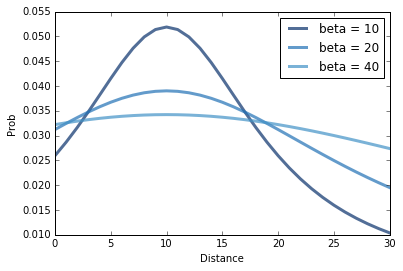

In [23]:
locations = range(0, 31)
alpha = 10
betas = [10, 20, 40]
thinkplot.PrePlot(num=len(betas))

for beta in betas:
    pmf = MakeLocationPmf(alpha, beta, locations)
    pmf.label = 'beta = %d' % beta
    thinkplot.Pdf(pmf)

thinkplot.Config(xlabel='Distance',
                ylabel='Prob')

Here are the marginal posterior distributions for `alpha` and `beta`.

alpha CI (14, 21)
beta CI (5, 31)


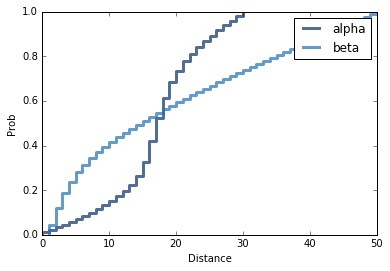

In [24]:
marginal_alpha = suite.Marginal(0, label='alpha')
marginal_beta = suite.Marginal(1, label='beta')

print('alpha CI', marginal_alpha.CredibleInterval(50))
print('beta CI', marginal_beta.CredibleInterval(50))

thinkplot.PrePlot(num=2)
    
thinkplot.Cdf(Cdf(marginal_alpha))
thinkplot.Cdf(Cdf(marginal_beta))
    
thinkplot.Config(xlabel='Distance',
                ylabel='Prob')

To visualize the joint posterior, I take slices for a few values of `beta` and plot the conditional distributions of `alpha`.  If the shooter is close to the wall, we can be somewhat confident of his position.  The farther away he is, the less certain we are.

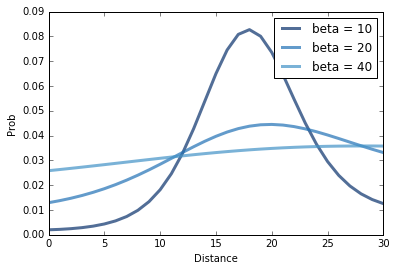

In [25]:
betas = [10, 20, 40]
thinkplot.PrePlot(num=len(betas))

for beta in betas:
    cond = suite.Conditional(0, 1, beta)
    cond.label = 'beta = %d' % beta
    thinkplot.Pdf(cond)

thinkplot.Config(xlabel='Distance',
                ylabel='Prob')

Another way to visualize the posterio distribution: a pseudocolor plot of probability as a function of `alpha` and `beta`.

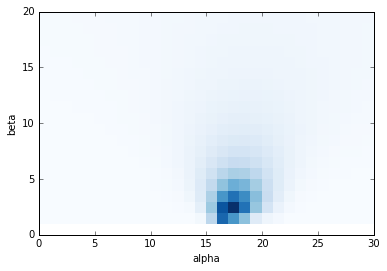

In [26]:
thinkplot.Contour(suite.GetDict(), contour=False, pcolor=True)

thinkplot.Config(xlabel='alpha',
                ylabel='beta',
                axis=[0, 30, 0, 20])

Here's another visualization that shows posterior credible regions.

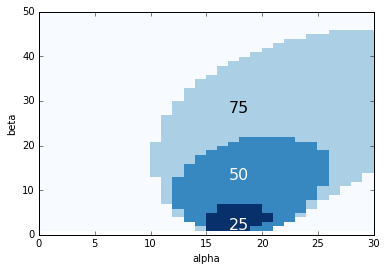

In [27]:
d = dict((pair, 0) for pair in suite.Values())

percentages = [75, 50, 25]
for p in percentages:
    interval = suite.MaxLikeInterval(p)
    for pair in interval:
        d[pair] += 1

thinkplot.Contour(d, contour=False, pcolor=True)
thinkplot.Text(17, 4, '25', color='white')
thinkplot.Text(17, 15, '50', color='white')
thinkplot.Text(17, 30, '75')

thinkplot.Config(xlabel='alpha',
                   ylabel='beta',
                   legend=False)

**Exercise:** From [John D. Cook](http://www.johndcook.com/blog/2010/07/13/lincoln-index/)

"Suppose you have a tester who finds 20 bugs in your program. You want to estimate how many bugs are really in the program. You know there are at least 20 bugs, and if you have supreme confidence in your tester, you may suppose there are around 20 bugs. But maybe your tester isn't very good. Maybe there are hundreds of bugs. How can you have any idea how many bugs there are? There’s no way to know with one tester. But if you have two testers, you can get a good idea, even if you don’t know how skilled the testers are.

Suppose two testers independently search for bugs. Let k1 be the number of errors the first tester finds and k2 the number of errors the second tester finds. Let c be the number of errors both testers find.  The Lincoln Index estimates the total number of errors as k1 k2 / c [I changed his notation to be consistent with mine]."

So if the first tester finds 20 bugs, the second finds 15, and they find 3 in common, we estimate that there are about 100 bugs.  What is the Bayesian estimate of the number of errors based on this data?

In [28]:
# Solution

from scipy.special import binom as choose

def binom(k, n, p):
    """Computes the rest of the binomial PMF.

    k: number of hits
    n: number of attempts
    p: probability of a hit
    """
    return p**k * (1-p)**(n-k)


class Lincoln(Suite, Joint):
    """Represents hypotheses about the number of errors."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: n, p1, p2
        data: k1, k2, c
        """
        n, p1, p2 = hypo
        k1, k2, c = data

        part1 = choose(n, k1) * binom(k1, n, p1)
        part2 = choose(k1, c) * choose(n-k1, k2-c) * binom(k2, n, p2)
        return part1 * part2

In [29]:
# Solution

data = 20, 15, 3
probs = np.linspace(0, 1, 31)
hypos = []
for n in range(32, 350):
    for p1 in probs:
        for p2 in probs:
            hypos.append((n, p1, p2))

suite = Lincoln(hypos)
suite.Update(data)

8.7543328146528235e-06

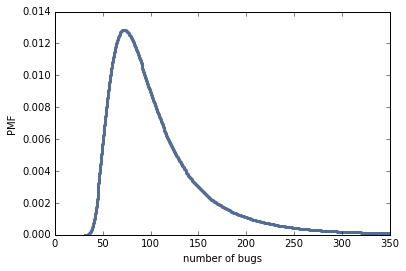

In [30]:
# Solution

n_marginal = suite.Marginal(0)
thinkplot.Pmf(n_marginal, label='n')
thinkplot.Config(xlabel='number of bugs',
                   ylabel='PMF')

In [31]:
# Solution

print('post mean n', n_marginal.Mean())
print('MAP n', n_marginal.MAP())

post mean n 105.457426627
MAP n 72


**Exercise:** The GPS problem.  According to [Wikipedia]()

￼
> GPS included a (currently disabled) feature called Selective Availability (SA) that adds intentional, time varying errors of up to 100 meters (328 ft) to the publicly available navigation signals. This was intended to deny an enemy the use of civilian GPS receivers for precision weapon guidance.
> [...]
> Before it was turned off on May 2, 2000, typical SA errors were about 50 m (164 ft) horizontally and about 100 m (328 ft) vertically.[10] Because SA affects every GPS receiver in a given area almost equally, a fixed station with an accurately known position can measure the SA error values and transmit them to the local GPS receivers so they may correct their position fixes. This is called Differential GPS or DGPS. DGPS also corrects for several other important sources of GPS errors, particularly ionospheric delay, so it continues to be widely used even though SA has been turned off. The ineffectiveness of SA in the face of widely available DGPS was a common argument for turning off SA, and this was finally done by order of President Clinton in 2000.

Suppose it is 1 May 2000, and you are standing in a field that is 200m square.  You are holding a GPS unit that indicates that your location is 51m north and 15m west of a known reference point in the middle of the field.

However, you know that each of these coordinates has been perturbed by a "feature" that adds random errors with mean 0 and standard deviation 30m.

1) After taking one measurement, what should you believe about your position?

Note: Since the intentional errors are independent, you could solve this problem independently for X and Y.  But we'll treat it as a two-dimensional problem, partly for practice and partly to see how we could extend the solution to handle dependent errors.

You can start with the code in gps.py.

2) Suppose that after one second the GPS updates your position and reports coordinates (48, 90).  What should you believe now?

3) Suppose you take 8 more measurements and get:

    (11.903060613102866, 19.79168669735705)
    (77.10743601503178, 39.87062906535289)
    (80.16596823095534, -12.797927542984425)
    (67.38157493119053, 83.52841028148538)
    (89.43965206875271, 20.52141889230797)
    (58.794021026248245, 30.23054016065644)
    (2.5844401241265302, 51.012041625783766)
    (45.58108994142448, 3.5718287379754585)

At this point, how certain are you about your location?

In [32]:
# Solution

from thinkbayes2 import EvalNormalPdf

class Gps(Suite, Joint):
    """Represents hypotheses about your location in the field."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: 
        data: 
        """
        std = 30
        meanx, meany = hypo
        x, y = data
        like = EvalNormalPdf(x, meanx, std)
        like *= EvalNormalPdf(y, meany, std)
        return like

In [33]:
# Solution

from itertools import product

coords = np.linspace(-100, 100, 101)
joint = Gps(product(coords, coords))
joint.Update((51, -15))

2.3287325820864544e-05

In [34]:
# Solution

joint.Update((48, 90))

4.3024101319712149e-06

In [35]:
# Solution

pairs = [(11.903060613102866, 19.79168669735705),
             (77.10743601503178, 39.87062906535289),
             (80.16596823095534, -12.797927542984425),
             (67.38157493119053, 83.52841028148538),
             (89.43965206875271, 20.52141889230797),
             (58.794021026248245, 30.23054016065644),
             (2.5844401241265302, 51.012041625783766),
             (45.58108994142448, 3.5718287379754585)]

joint.UpdateSet(pairs)

1.1118148191216602e-34

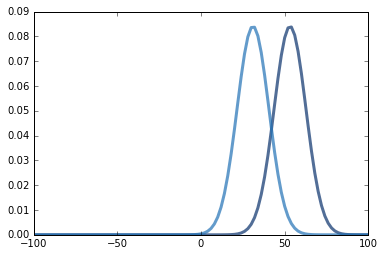

In [36]:
# Solution

thinkplot.PrePlot(2)
pdfx = joint.Marginal(0)
pdfy = joint.Marginal(1)
thinkplot.Pdf(pdfx, label='posterior x')
thinkplot.Pdf(pdfy, label='posterior y')

In [37]:
# Solution

print(pdfx.Mean(), pdfx.Std())
print(pdfy.Mean(), pdfy.Std())

53.1957132094 9.48680494799
31.0728627918 9.48683298048


**Exercise:** [The Flea Beetle problem from DASL](http://lib.stat.cmu.edu/DASL/Datafiles/FleaBeetles.html)

Datafile Name: Flea Beetles

Datafile Subjects: Biology

Story Names: Flea Beetles

Reference: Lubischew, A.A. (1962) On the use of discriminant functions in taxonomy. Biometrics, 18, 455-477. Also found in: Hand, D.J., et al. (1994) A Handbook of Small Data Sets, London: Chapman & Hall, 254-255.

Authorization: Contact Authors

Description: Data were collected on the genus of flea beetle Chaetocnema, which contains three species: concinna (Con), heikertingeri (Hei), and heptapotamica (Hep). Measurements were made on the width and angle of the aedeagus of each beetle. The goal of the original study was to form a classification rule to distinguish the three species.

Number of cases: 74

Variable Names:

Width: The maximal width of aedeagus in the forpart (in microns)

Angle: The front angle of the aedeagus (1 unit = 7.5 degrees)

Species: Species of flea beetle from the genus Chaetocnema


Suggestions: 

1. Plot CDFs for the width and angle data, broken down by species, to get a visual sense of whether the normal distribution is a good model.

2. Use the data to estimate the mean and standard deviation for each variable, broken down by species.

3. Given a joint posterior distribution for `mu` and `sigma`, what is the likelihood of a given datum?

4. Write a function that takes a measured width and angle and returns a posterior PMF of species.

5. Use the function to classify each of the specimens in the table and see how many you get right.


In [38]:
import pandas as pd

df = pd.read_csv('flea_beetles.csv', delimiter='\t')
df.head()

,Width,Angle,Species
0,150,15,Con
1,147,13,Con
2,144,14,Con
3,144,16,Con
4,153,13,Con


In [39]:
def plot_cdfs(df, col):
    for name, group in df.groupby('Species'):
        cdf = Cdf(group[col], label=name)
        thinkplot.Cdf(cdf)
    
    thinkplot.Config(xlabel=col, legend=True, loc='lower right')

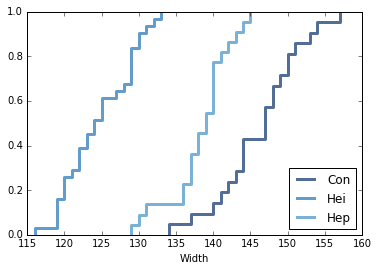

In [40]:
plot_cdfs(df, 'Width')

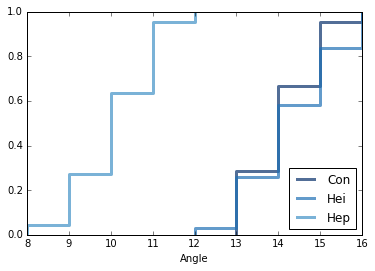

In [41]:
plot_cdfs(df, 'Angle')

In [42]:
from thinkbayes2 import EvalNormalPdf

class Beetle(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        data: sequence of measurements
        hypo: mu, sigma
        """
        mu, sigma = hypo
        likes = EvalNormalPdf(data, mu, sigma)
        return np.prod(likes)
    
    def PredictiveProb(self, data):
        """Compute the posterior total probability of a datum.
        
        data: sequence of measurements
        """
        total = 0
        for (mu, sigma), prob in self.Items():
            likes = norm.pdf(data, mu, sigma)
            total += prob * np.prod(likes)
        return total

In [43]:
from itertools import product

def MakeWidthSuite(data):
    mus = np.linspace(115, 160, 51)
    sigmas = np.linspace(1, 10, 51)
    suite = Beetle(product(mus, sigmas))
    suite.Update(data)
    return suite

In [44]:
groups = df.groupby('Species')

Con 0.0200863522822
Hei 0.00368097211374
Hep 0.0867791556717


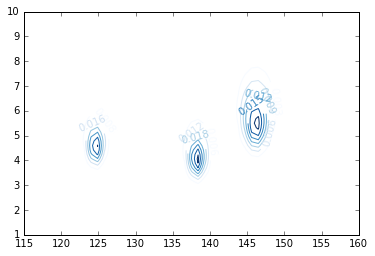

In [45]:
for name, group in groups:
    suite = MakeWidthSuite(group.Width)
    thinkplot.Contour(suite)
    print(name, suite.PredictiveProb(137))

In [46]:
def MakeAngleSuite(data):
    mus = np.linspace(8, 16, 101)
    sigmas = np.linspace(0.1, 2, 101)
    suite = Beetle(product(mus, sigmas))
    suite.Update(data)
    return suite

Con 0.20957983351
Hei 0.181327548441
Hep 0.0106017571682


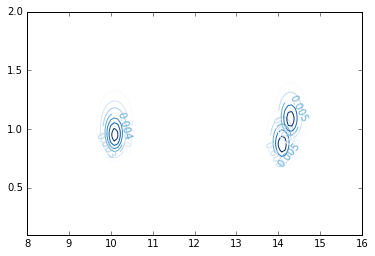

In [47]:
for name, group in groups:
    suite = MakeAngleSuite(group.Angle)
    thinkplot.Contour(suite)
    print(name, suite.PredictiveProb(13))

In [48]:
class Species:
    
    def __init__(self, name, suite_width, suite_angle):
        self.name = name
        self.suite_width = suite_width
        self.suite_angle = suite_angle
        
    def __str__(self):
        return self.name
        
    def Likelihood(self, data):
        width, angle = data
        like1 = self.suite_width.PredictiveProb(width)
        like2 = self.suite_angle.PredictiveProb(angle)
        return like1 * like2

In [49]:
species = {}

for name, group in groups:
    suite_width = MakeWidthSuite(group.Width)
    suite_angle = MakeAngleSuite(group.Angle)
    species[name] = Species(name, suite_width, suite_angle)

In [50]:
species['Con'].Likelihood((145, 14))

0.027390362241871791

In [51]:
class Classifier(Suite):
    
    def Likelihood(self, data, hypo):
        return hypo.Likelihood(data)

In [52]:
suite = Classifier(species.values())
suite.Print()

Hep 0.333333333333
Hei 0.333333333333
Con 0.333333333333


In [53]:
suite.Update((145, 14))
suite.Print()

Hep 0.00116844449591
Hei 0.000689941368376
Con 0.998141614136
